In [1]:
import psycopg2
import os
from shapely.geometry import MultiPoint, mapping
import shapely.wkt
import numpy as np
import fiona
from fiona.crs import from_epsg
import geopandas as gpd
import pandas as pd
from osgeo import  ogr, osr
from sys import argv
import sys
import csv
import shapefile
from sklearn.neighbors import NearestNeighbors
from pandas import DataFrame
from qgis.core import Qgis, QgsProject, QgsMapSettings, QgsLayerDefinition,QgsRasterLayer
from pathlib import Path 

In [2]:
# Tell Python where you will get processing from
sys.path.append(r'C:\OSGeo4W\apps\qgis\python\plugins')
import processing

In [2]:
connection = psycopg2.connect(user = "postgres",
                              password = "Sagitario137",
                              port = "5432",
                              database = "postgres")

db_cursor = connection.cursor()
# Print PostgreSQL Connection properties

db_cursor.execute("""CREATE TABLE osm_copy_way AS (SELECT * FROM planet_osm_ways);""")

db_cursor.execute("""SELECT table_name FROM information_schema.tables
   WHERE table_schema = 'public'""")

for table in db_cursor.fetchall():
    print(table)

('geography_columns',)
('geometry_columns',)
('spatial_ref_sys',)
('planet_osm_point',)
('osm_copy_way',)
('planet_osm_polygon',)
('planet_osm_ways',)
('planet_osm_rels',)
('planet_osm_roads',)
('planet_osm_nodes',)


In [3]:
db_cursor.execute("""SELECT id, nodes, tags FROM osm_copy_way ORDER BY id FETCH FIRST 1000 ROW ONLY;""")
print("Selecting rows from ways table using cursor.fetchall")
way_records = db_cursor.fetchall() 
    
print("Print each row and it's columns values")
for row in way_records:
   print("Id = ", row[0], )
   print("Nodes = ", row[1])
   print("Tags  = ", row[2], "\n")

Selecting rows from ways table using cursor.fetchall
Print each row and it's columns values
Id =  2080
Nodes =  [571329, 571328, 571327, 545676]
Tags  =  ['name', 'Møllehusene', 'highway', 'unclassified'] 

Id =  2081
Nodes =  [546419, 3763710931, 3763710939, 3763710938, 3763710943, 3763710945, 3763710947, 1015329269, 4038756297, 574928, 331345585, 570284, 6356842769, 6356842768, 6356842770, 6356842776, 765091656, 3439361903, 570283, 2122682936, 1755113164, 1296754626, 570288, 4038756308, 2619629970, 482455446, 7155740565, 3317651087, 570289]
Tags  =  ['cycleway', 'track', 'highway', 'tertiary', 'maxspeed', '50', 'name', 'Møllehusvej', 'source', 'Local knowledge', 'surface', 'asphalt'] 

Id =  2082
Nodes =  [570226, 3253490576, 26372628, 1964063432, 331345959, 570224, 570222, 570221, 2257598730]
Tags  =  ['cycleway', 'track', 'highway', 'secondary', 'lit', 'yes', 'maxspeed', '50', 'name', 'Byvolden', 'ref', 'O1', 'sidewalk', 'both', 'source:maxspeed', 'DK:urban', 'surface', 'asphalt'] 

Nodes =  [7244204, 3378861474, 6331424643, 7244205]
Tags  =  ['bicycle', 'yes', 'cycleway', 'no', 'foot', 'yes', 'highway', 'unclassified', 'lanes', '2', 'lit', 'yes', 'maxspeed', '50', 'name', 'Amaliegade', 'sidewalk', 'both', 'source:maxspeed', 'DK:urban', 'surface', 'asphalt'] 

Id =  1702964
Nodes =  [7741059, 276359703]
Tags  =  ['cycleway', 'no', 'highway', 'residential', 'lanes', '2', 'lit', 'yes', 'maxspeed', '40', 'maxweight', '12', 'name', 'Toldbodgade', 'sidewalk', 'both', 'source:maxspeed', 'sign', 'surface', 'asphalt'] 

Id =  1702965
Nodes =  [7244208, 7741066, 564838229, 3035052617, 697822]
Tags  =  ['cycleway:left', 'opposite_track', 'cycleway:right', 'shared_lane', 'highway', 'residential', 'lanes', '1', 'lit', 'yes', 'maxspeed', '50', 'name', 'Nyhavn', 'oneway', 'yes', 'oneway:bicycle', 'no', 'sidewalk', 'left', 'source:maxspeed', 'DK:urban', 'surface', 'asphalt', 'tourist_bus', 'no'] 

Id =  1702966
Nodes =  [268690821, 3035052618, 1912861414, 277052769, 3092852130, 

Nodes =  [8086671, 1619442473, 6985968283, 1619442476]
Tags  =  ['highway', 'tertiary', 'lit', 'yes', 'maxspeed', '50', 'name', 'Strandlodsvej', 'oneway', 'yes', 'source:maxspeed', 'DK:urban', 'surface', 'asphalt'] 

Id =  1813861
Nodes =  [8892842, 2688864313, 280270264, 6805490280, 7726649]
Tags  =  ['highway', 'residential', 'lit', 'yes', 'maxspeed', '50', 'maxspeed:advisory', '30', 'name', 'Torben Oxes Allé', 'source:maxspeed', 'DK:urban', 'surface', 'asphalt'] 

Id =  1813862
Nodes =  [7726662, 7448948454, 5996601376, 7235689]
Tags  =  ['cycleway', 'track', 'highway', 'residential', 'lanes', '2', 'lit', 'yes', 'maxspeed', '50', 'name', 'Thorshavnsgade', 'sidewalk', 'both', 'source:maxspeed', 'DK:urban', 'surface', 'asphalt'] 

Id =  1813863
Nodes =  [1625107367, 2591352613, 7448948456, 297924453]
Tags  =  ['highway', 'residential', 'lit', 'yes', 'maxspeed', '50', 'name', 'Reykjaviksgade', 'source:maxspeed', 'DK:urban', 'surface', 'asphalt'] 

Id =  1813864
Nodes =  [1640257226, 68

Tags  =  ['highway', 'residential', 'lit', 'yes', 'maxspeed', '50', 'name', 'Hammershusgade', 'source:maxspeed', 'DK:urban', 'surface', 'asphalt'] 

Id =  1880647
Nodes =  [8082294, 3646998397, 3646998398, 8082295]
Tags  =  ['highway', 'residential', 'lit', 'yes', 'maxspeed', '50', 'name', 'Ragnagade', 'source:maxspeed', 'DK:urban', 'surface', 'asphalt'] 

Id =  1880648
Nodes =  [8082299, 8082301, 8082300]
Tags  =  ['highway', 'residential', 'lit', 'yes', 'maxspeed', '15', 'name', 'Klostervænget', 'source:maxspeed', 'sign', 'surface', 'sett'] 

Id =  1880650
Nodes =  [8082305, 7373450479, 7373450474, 17343217]
Tags  =  ['highway', 'residential', 'lit', 'yes', 'maxspeed', '40', 'name', 'Ved Klosteret', 'oneway', 'yes', 'source:maxspeed', 'DK:zone:40', 'surface', 'asphalt'] 

Id =  1880651
Nodes =  [8082308, 1623964473, 5754863554, 8082309, 8082310, 294222469]
Tags  =  ['highway', 'residential', 'lit', 'yes', 'maxspeed', '40', 'name', 'Vejrøgade', 'source:maxspeed', 'DK:zone:40'] 

Id = 


Id =  1881379
Nodes =  [7640645, 5143533899, 7640647, 3632938864, 7640653, 3632938863, 7640657, 5143535802, 7640661]
Tags  =  ['cycleway', 'no', 'highway', 'residential', 'lanes', '1', 'lit', 'yes', 'maxspeed', '50', 'name', 'Valkendorfsgade', 'sidewalk', 'both', 'surface', 'cobblestone', 'wikidata', 'Q16325332', 'wikipedia', 'da:Valkendorfsgade'] 

Id =  1881380
Nodes =  [1464973521, 5195460716, 5195460713, 1464973640, 1464973652, 1590184752, 1451702407, 4675392122, 1490166493, 5195460699, 1490166534, 4675392121, 1451743078, 1464973521]
Tags  =  ['name', 'Gråbrødretorv', 'name:ko', '그레이 브라더 광장', 'place', 'square', 'tourism', 'attraction', 'wikidata', 'Q4572693', 'wikipedia', 'da:Gråbrødretorv'] 

Id =  1881382
Nodes =  [286657007, 277052528, 706250]
Tags  =  ['lit', 'yes', 'name', 'Store Kannikestræde', 'oneway', 'yes', 'highway', 'pedestrian', 'surface', 'paving_stones', 'motor_vehicle', 'destination'] 

Id =  1881383
Nodes =  [7217659, 8088643]
Tags  =  ['highway', 'residential', '

In [4]:
db_cursor.execute("""SELECT count(*) FROM osm_copy_way;""")
Num_rows=db_cursor.fetchall() 
print("Num Rows Table Ways is:",Num_rows)
highway=['motorway','trunk','primary','secondary','tertiary','unclassified','residential']

Num Rows Table Ways is: [(4969424,)]


In [5]:
list_highway=list()
for idx in highway:
    print(idx)
    db_cursor.execute("""CREATE TABLE highway_"""+idx+"""
      AS (SELECT *FROM osm_copy_way WHERE tags::varchar LIKE '%"""+idx+"""%');""")
    db_cursor.execute("""SELECT count(*) FROM highway_"""+idx+""";""")
    Num_rows=db_cursor.fetchall() 
    print("Num Rows Table "+idx+" Ways is:",Num_rows)
    
    db_cursor.execute("""CREATE TABLE highway_"""+idx+"""_nodes
                       AS(SELECT r.*
                            , (ARRAY (
                             SELECT CAST(n.lat AS FLOAT)/10000000
                             FROM   unnest(r.nodes) WITH ORDINALITY AS a( id, ord)
                             JOIN   planet_osm_nodes n ON n.id = a.id
                             ORDER  BY a.ord
                             )
                              ) AS lat
                            , (ARRAY (
                             SELECT CAST(n.lon AS FLOAT)/10000000
                             FROM   unnest(r.nodes) WITH ORDINALITY AS a( id, ord)
                             JOIN   planet_osm_nodes n ON n.id = a.id
                             ORDER  BY a.ord
                             )
                              ) AS lon                                                                            
                       FROM highway_"""+idx+""" r);""")

    db_cursor.execute("""DROP TABLE highway_"""+idx+""";""")

    db_cursor.execute("""SELECT id, nodes, tags,lat,lon FROM highway_"""+idx+"""_nodes ORDER BY id;""")
    way_records = db_cursor.fetchall() 
    ArrayWay=list()
    for row in way_records:
        
       ArrayCorr=list()
       roadID=row[0]
    
    
       for index in range(len(row[3])):
            
            nodes=row[1]
            lat=row[3]
            lon=row[4]
            Var=[nodes[index],lon[index],lat[index],roadID]
            ArrayCorr.append(Var)
       ArrayWay.append(ArrayCorr) 
    list_highway.append(ArrayWay) 

motorway
Num Rows Table motorway Ways is: [(4087,)]
trunk
Num Rows Table trunk Ways is: [(1404,)]
primary
Num Rows Table primary Ways is: [(8092,)]
secondary
Num Rows Table secondary Ways is: [(16509,)]
tertiary
Num Rows Table tertiary Ways is: [(46301,)]
unclassified
Num Rows Table unclassified Ways is: [(41333,)]
residential
Num Rows Table residential Ways is: [(185830,)]


In [6]:
db_cursor.close()
connection.close()
print("PostgreSQL connection is closed")

PostgreSQL connection is closed


In [7]:
LAT_samples=list()
LON_samples=list()

for type_road in range(len(list_highway)):
    for num_roads in range(len(list_highway[type_road])):
        for num_points in range(len(list_highway[type_road][num_roads])):
            for idx,XY in enumerate(list_highway[type_road][num_roads][num_points][1:3]):
                if (idx==0):
                    LAT_samples.append(XY)
                else:
                    LON_samples.append(XY)      
samples=np.column_stack((LAT_samples  ,LON_samples))  
print(np.shape(samples))
df = DataFrame (samples,columns=['Latitude','Longitude'])

(2825573, 2)


In [8]:
df.drop_duplicates(keep="first",inplace=True)
df.shape

(2441673, 2)

In [9]:
neigh = NearestNeighbors(n_neighbors=100
                         , radius=6)
neigh.fit(df)
search=neigh.kneighbors([[9.3878187, 55.002422]], 8, return_distance=True)

In [10]:
search

(array([[0.        , 0.00037771, 0.00054528, 0.00118525, 0.00210025,
         0.00229291, 0.0023009 , 0.00248476]]),
 array([[ 39115,  46532,  39116,  46531,  46530, 748021, 748022, 748020]],
       dtype=int32))

In [3]:
from qgis.analysis import QgsNativeAlgorithms
from qgis.core import (
     QgsApplication,
     QgsProcessingFeedback,
     QgsVectorLayer
)
import sys

C:\OSGeo4W\apps\Python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
QgsApplication.setPrefixPath(r'C:\OSGeo4W64\apps\qgis', True)
qgs = QgsApplication([], False)
qgs.initQgis()
sys.path.append(r'C:\OSGeo4W64\apps\qgis\python\plugins')

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
plt.ion()

import processing
from processing.core.Processing import Processing
Processing.initialize()
QgsApplication.processingRegistry().addProvider(QgsNativeAlgorithms())
for alg in QgsApplication.processingRegistry().algorithms():
        print(alg.id(), "--->", alg.displayName())

gdal:aspect ---> Aspect
gdal:assignprojection ---> Assign projection
gdal:buffervectors ---> Buffer vectors
gdal:buildvirtualraster ---> Build virtual raster
gdal:buildvirtualvector ---> Build virtual vector
gdal:cliprasterbyextent ---> Clip raster by extent
gdal:cliprasterbymasklayer ---> Clip raster by mask layer
gdal:clipvectorbyextent ---> Clip vector by extent
gdal:clipvectorbypolygon ---> Clip vector by mask layer
gdal:colorrelief ---> Color relief
gdal:contour ---> Contour
gdal:contour_polygon ---> Contour Polygons
gdal:convertformat ---> Convert format
gdal:dissolve ---> Dissolve
gdal:executesql ---> Execute SQL
gdal:extractprojection ---> Extract projection
gdal:fillnodata ---> Fill nodata
gdal:gdal2tiles ---> gdal2tiles
gdal:gdal2xyz ---> gdal2xyz
gdal:gdalinfo ---> Raster information
gdal:gridaverage ---> Grid (Moving average)
gdal:griddatametrics ---> Grid (Data metrics)
gdal:gridinversedistance ---> Grid (Inverse distance to a power)
gdal:gridinversedistancenearestneighbor

native:wedgebuffers ---> Create wedge buffers
native:writevectortiles_mbtiles ---> Write Vector Tiles (MBTiles)
native:writevectortiles_xyz ---> Write Vector Tiles (XYZ)
native:zonalhistogram ---> Zonal histogram
native:zonalstatistics ---> Zonal statistics
qgis:advancedpythonfieldcalculator ---> Advanced Python field calculator
qgis:barplot ---> Bar plot
qgis:basicstatisticsforfields ---> Basic statistics for fields
qgis:boxplot ---> Box plot
qgis:checkvalidity ---> Check validity
qgis:climbalongline ---> Climb Along Line
qgis:concavehull ---> Concave hull (alpha shapes)
qgis:convertgeometrytype ---> Convert geometry type
qgis:definecurrentprojection ---> Define Shapefile projection
qgis:delaunaytriangulation ---> Delaunay triangulation
qgis:deletecolumn ---> Drop field(s)
qgis:distancematrix ---> Distance matrix
qgis:distancetonearesthublinetohub ---> Distance to nearest hub (line to hub)
qgis:distancetonearesthubpoints ---> Distance to nearest hub (points)
qgis:eliminateselectedpoly

C:\OSGeo4W\apps\Python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


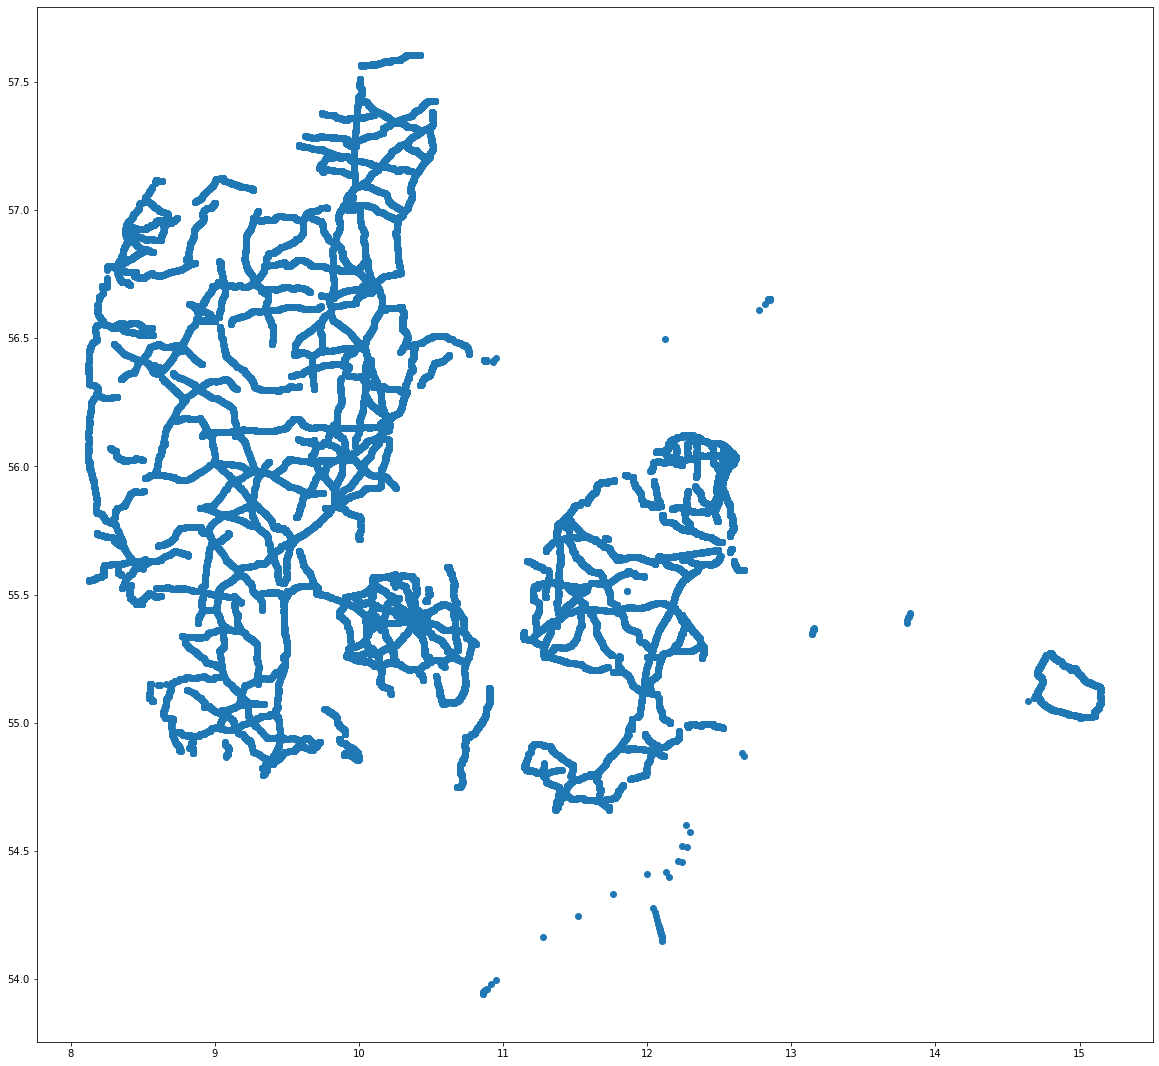

In [10]:
source = r"C:\Users\daniel\Pictures\Maps\Secondary.geojson"
inputvector = QgsVectorLayer(r"C:\Users\daniel\Pictures\Maps\Secondary.geojson")
fig, ax = plt.subplots(figsize = (20,20))
gpd.read_file(source).plot(ax=ax);

TypeError: QgsLayerDefinition.loadLayerDefinition(): arguments did not match any overloaded call:
  overload 1: argument 2 has unexpected type 'QgsLayerTreeGroup'
  overload 2: argument 1 has unexpected type 'str'

In [70]:
layer = iface.activeLayer()

C:\OSGeo4W\apps\Python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: 'NoneType' object has no attribute 'activeLayer'

invalid layer
